# Sieci neuronowe i Deep Learning
# Temat 5: Moduł torch.nn w bibliotece PyTorch

Potrzebne pakiety i ich rekomendowane minimalne wersje:
`numpy`: 1.21.2,
`scipy`: 1.7.0,
`sklearn`: 1.0.0,
`matplotlib`: 3.4.3,
`torch`: 1.9.0.

## Budowanie modeli sztucznych sieci neuronowych w PyTorch (moduł torch.nn)

### Budowa regresji liniowej w PyTorch – jako przykład wprowadzający

Zaczniemy od zbudowania prostego modelu regresji liniowej.

In [1]:
# import torch
import numpy as np
import matplotlib.pyplot as plt

[[0.]
 [1.]
 [2.]
 [3.]
 [4.]
 [5.]
 [6.]
 [7.]
 [8.]
 [9.]]
[1.  1.3 3.1 2.  5.  6.3 6.6 7.4 8.  9. ]


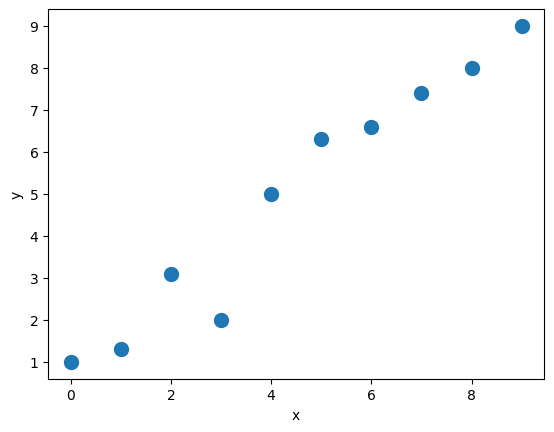

In [2]:
# Tworzymy sztuczny zbiór danych:

X_train = np.arange(10, dtype='float32').reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0], dtype='float32')

plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')

print(X_train)
print(y_train)
plt.show()

`Dataset` jest klasą abstrakcyjną w PyTorch, która definiuje kluczowe metody, które muszą zostać zaimplementowane przez niestandardowe ,,zestawy danych", czyli `__len__()` oraz `__getitem__()`. Każda klasa dziedzicząca po Dataset musi zdefiniować te metody, aby można było stworzyć iterowalny zestaw danych, który będzie kompatybilny z `DataLoader` w PyTorch.

`__len__(self)` powinna zwracać liczbę przykładów w zestawie danych.
`__getitem__(self, index)` powinna zwracać pojedynczy przykład (oraz ewentualnie etykietę) z zestawu danych odpowiadający danemu indeksowi.

**`TensorDataset`** to konkretna implementacja klasy `Dataset`, która przyjmuje tensory jako argumenty i przechowuje je. Metoda `__getitem__` wywołana na instancji `TensorDataset` zwraca konkretną próbkę i odpowiadającą jej etykietę jako tensory.
Jest to prosty wrapper, który po prostu zwraca wskazane przez index dane, bez dodatkowych przekształceń.

In [3]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Standaryzujemy cechy i zamieniamy na tensor:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm)

y_train = torch.from_numpy(y_train).float()  # Uwaga: torch.from_numpy() przyjmuje tablice NumPy

# Tworzymy obiekt typu Dataset (tutaj dokładniej TensorDataset) ze zbiorem treningowym:
train_ds = TensorDataset(X_train_norm, y_train)

# Tworzymy obiekt typu DataLoader do obsługi naszego Dataset:
batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

Dla tego prostego przykładu jednowymiarowego modelu regresji liniowej $z = w x + b$ zaimplementujemy całą metodę od podstaw.

In [4]:
torch.manual_seed(1)

# Definiujemy parametry modelu (weight (w) oraz bias (b)):
weight = torch.randn(1)  # Inicjalizacja
weight.requires_grad_()  # Ustawia flagę requires_grad tensora weight na True
                         # - PyTorch będzie śledził wszystkie operacje na tym tensorze,
                         # aby umożliwić obliczenie gradientów podczas kroku wstecznej propagacji

bias = torch.zeros(1, requires_grad=True)

# Definiujemy funkcję model(), która przekształca input w output metody regresji liniowej:
def model(xb):
    return xb @ weight + bias  # @ to mnożenie macierzy

# Definiujemy funkcję straty (tutaj będzie to MSE):
def loss_fn(input, target):
    return (input-target).pow(2).mean()

W celu wyliczenia wag naszego modelu wykorzystamy algorytm SGD. Poniżej znajduje się jego implementacja, ale można też wykorzystać gotową funkcję z pakietu
`torch.optim`.

Do obliczania gradientów wykorzystana została funkcja
`torch.autograd.backward()`
z biblioteki PyTorch.

In [5]:
learning_rate = 0.001
num_epochs = 200
log_epochs = 10

for epoch in range(num_epochs):              # Pętla po epokach
    for x_batch, y_batch in train_dl:        # Pętla po mini-batchach
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()                      # Automatyczne obliczenie gradientów funkcji straty względem parametrów modelu

        with torch.no_grad():
            weight -= weight.grad * learning_rate
            bias -= bias.grad * learning_rate
            weight.grad.zero_()
            bias.grad.zero_()                # Zerujemy gradienty, bo PyTorch akumuluje je domyślnie w kolejnych backward()
 
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss 45.0782
Epoch 10  Loss 26.4366
Epoch 20  Loss 1.5918
Epoch 30  Loss 14.1307
Epoch 40  Loss 11.6038
Epoch 50  Loss 6.3084
Epoch 60  Loss 0.6349
Epoch 70  Loss 3.1374
Epoch 80  Loss 1.9999
Epoch 90  Loss 0.3133
Epoch 100  Loss 0.7653
Epoch 110  Loss 1.0039
Epoch 120  Loss 0.0235
Epoch 130  Loss 0.5176
Epoch 140  Loss 0.0759
Epoch 150  Loss 1.8789
Epoch 160  Loss 0.0008
Epoch 170  Loss 0.0866
Epoch 180  Loss 0.0646
Epoch 190  Loss 0.0011


Final Parameters: 2.6696107387542725 4.879678249359131


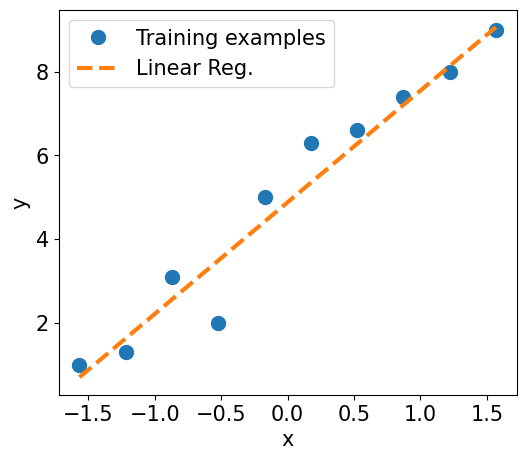

In [6]:
# Wypisujemy parametry modelu oraz rysujemy jego wykres:

print('Final Parameters:', weight.item(), bias.item())

X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

### Uczenie modeli z wykorzystaniem modułów torch.nn oraz torch.optim

W module `torch.nn` dostępne są (m.in. oczywiście) najważniejsze funkcje straty, a w module `torch.optim` - najważniejsze algorytmy optymalizacyjne, przydatne w kontekście uczenia modeli na podstawie gradientów.

Poniższy przykład pokazuje, jak można z tego korzystać (to samo zadanie co powyżej).

In [7]:
import torch.nn as nn

# Konfigurujemy prosty model liniowy, funkcję straty oraz optymalizator:
input_size = 1
output_size = 1
model = nn.Linear(input_size, output_size)  # Reprezentuje warstwę liniową (tj. pełną warstwę połączoną
                                            # bez funkcji aktywacji). Ta warstwa będzie przekształcać
                                            # wejścia/e o rozmiarze input_size do wyjść/a o rozmiarze output_size

loss_fn = nn.MSELoss(reduction='mean')  # reduction='mean' - strata będzie uśredniona po wszystkich przykładach

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Aby przeprowadzić proces uczenia modelu, wystarczy wywołać
metodę `step`:

In [8]:
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        # 1. Liczymy predykcje
        pred = model(x_batch)[:, 0] 

        # 2. Obliczamy stratę
        loss = loss_fn(pred, y_batch)

        # 3. Obliczamy gradienty
        loss.backward()

        # 4. Aktualizujemy parametry z wykorzystaniem gradientów
        optimizer.step()

        # 5. Resetujemy gradienty do zera
        optimizer.zero_grad()
        
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss 24.6684
Epoch 10  Loss 29.1377
Epoch 20  Loss 20.9207
Epoch 30  Loss 0.1257
Epoch 40  Loss 12.4922
Epoch 50  Loss 1.7845
Epoch 60  Loss 7.6425
Epoch 70  Loss 2.5606
Epoch 80  Loss 0.0157
Epoch 90  Loss 0.7548
Epoch 100  Loss 0.8412
Epoch 110  Loss 0.4923
Epoch 120  Loss 0.0823
Epoch 130  Loss 0.0794
Epoch 140  Loss 0.0891
Epoch 150  Loss 0.0973
Epoch 160  Loss 0.1043
Epoch 170  Loss 0.1103
Epoch 180  Loss 0.0009
Epoch 190  Loss 0.0764


Final Parameters: 2.6496422290802 4.87706995010376


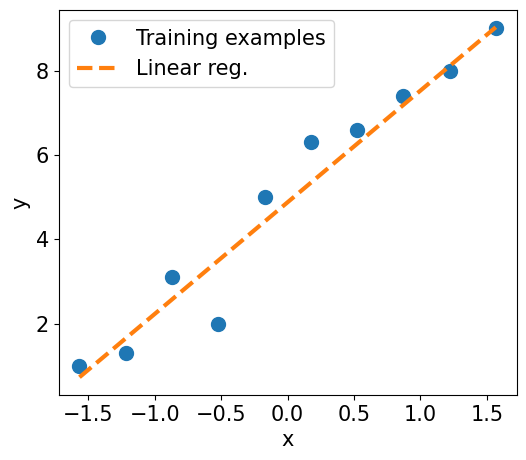

In [9]:
# Wypisujemy parametry modelu oraz rysujemy jego wykres:

print('Final Parameters:', model.weight.item(), model.bias.item())
 
X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm.detach().numpy(), y_train.detach().numpy(), 'o', markersize=10)
# plt.plot(X_test_norm.detach().numpy(), y_pred.detach().numpy(), '--', lw=3)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

## Sieć MLP dla danych Iris

W module `torch.nn` dostępne są zdefiniowane warstwy, które można wykorzystać do wygodnej budowy modeli sieci neuronowych. Poniżej można zobaczyć, jak to funkcjonuje na przykładzie zadania klasyfikacji trzech gatunków irysów (zbiór danych Iris; por. temat 1).

Zbiór danych Iris:
* 150 przykładów (każdy reprezentuje pojedynczy kwiat irysa),
* cechy: długość działki kielicha (*sepal length*) - w centymetrach, szerokość działki kielicha (*sepal width*) - w centymetrach, długość płatka (*petal length*) - w centymetrach, szerokość płatka (*petal width*) - w centymetrach,
* zmienna *class* - trzy gatunki irysów: setosa, virginica, versicolor,
* każdy gatunek kwiatu irysa jest reprezentowany przez 50 próbek.

In [10]:
# Pobieramy zbiór danych i dzielimy go losowo na zbiór treningowy (2/3) oraz testowy (1/3):

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split 

iris = load_iris()
X = iris['data']
y = iris['target']
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1)

In [11]:
# Standaryzacja + obiekt TensorDataset (ze zbiorem uczącym) + odpowiadający obiekt DataLoader:

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train) 

train_ds = TensorDataset(X_train_norm, y_train)

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

Jesteśmy gotowi, aby przystąpić do budowania modelu z wykorzystaniem modułu `torch.nn`.

W szczególności klasa `nn.Module` daje możliwość 
konstruowania sieci z gotowych warstw. Listę gotowych warstw znaleźć można pod adresem https://pytorch.org/docs/stable/nn.html.

W naszym przykładzie zastosujemy warstwę **liniową** (czasami po ang. nazywaną też *fully connected layer* lub *dense layer*):

$$f(w \times x + b),$$

gdzie $x$ to tensor z wartościami wejściowymi, $w$ oraz $b$ to macierz z wagami i wektor obciążeń, natomiast $f$ to funkcja aktywacyjna.

Skonstruujmy sieć z dwiema warstwami:
- pierwsza warstwa przekształca cechy przez 16 neuronów,
- druga warstwa na wejście otrzymuje wyjście z pierwszej warstwy i przekształca je przez 3 neurony (ponieważ mamy 3 klasy).

W poniższym fragmencie kodu definiowana jest klasa `Model`, która dziedziczy po `nn.Module` z PyTorch. Jest to model sieci neuronowej z jedną warstwą ukrytą.

In [12]:
class Model(nn.Module):

# W metodzie inicjalizacji określamy warstwy sieci:
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()  # Wywołanie konstruktora klasy bazowej nn.Module
                            # (super() jest używane do odwołania się do klasy bazowej)
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  

# Metoda forward: definiujemy sposób, w jaki dane wejściowe x są przetwarzane przez model:
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)  # Będzie wyjaśnione
        return x

In [13]:
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3

model = Model(input_size, hidden_size, output_size)

learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()  # Będzie wyjaśnione
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Będzie wyjaśnione

In [14]:
# Uczenie modelu (przez 100 epok):

num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)  # Predykcja na x_batch
        loss = loss_fn(pred, y_batch.long())  # Obliczanie funkcji straty między pred a y_batch.long()
                                              # Konwersja .long() jest wymagana przez funkcję straty CrossEntropyLoss
        loss.backward()  # Wsteczna propagacja błędów: oblicza gradienty funkcji straty
        optimizer.step()  # Aktualizuje parametry modelu przy użyciu obliczonych gradientów
        optimizer.zero_grad()  # Zeruje gradienty w optymalizatorze, aby były gotowe do następnej iteracji
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

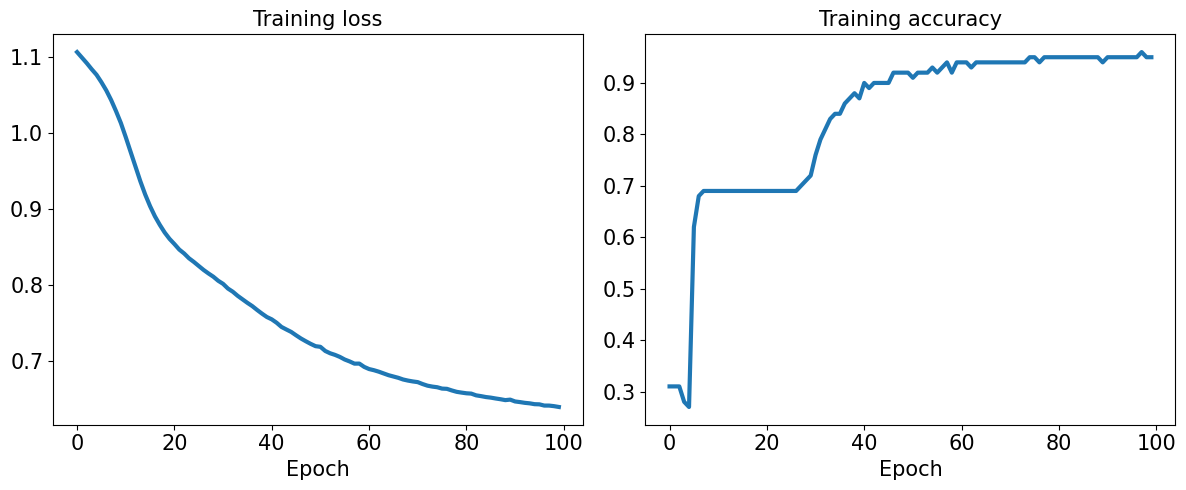

In [15]:
# loss_hist zawiera średnie straty z kolejnych epok uczenia
# accuracy_hist zawiera dokładności predykcji z kolejnych epok uczenia
# Wizualizacja procesu uczenia:

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()


plt.show()

### Sprawdzenie na zbiorze testowym

In [16]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)  # Należy pamiętać o standaryzacji,
                                                             # ponieważ na takich danych model był uczony
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test) 
pred_test = model(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


### Zapisywanie i ponowne wczytywanie wyuczonych modeli

UWAGA: Od PyTorch 2.6 zmienił się domyślny sposób wczytywania modeli: PyTorch teraz domyślnie zakłada, że pliki .pt zawierają tylko wagi, a nie cały obiekt (model z klasą i logiką).
Poniższy kod może wyrzucić błędy. Patrz na rozwiązanie poniżej (zalecane).

Zbudowany model można zapisać na dysku w następujący sposób (`save(model)` zapisze zarówno architekturę modelu, jak i wszystkie wyliczone parametry):

In [17]:
# path = 'iris_classifier.pt'  # Do serializacji wykorzystuje się format pliku .pt lub .pth
                             # (zalecane przez PyTorch dla zapisywania modeli)

# torch.save(model, path)

Załadowanie modelu z dysku:

In [18]:
# model_new = torch.load(path)
# model_new.eval()

Zapisywanie samych parametrów modelu:

In [19]:
path = 'iris_classifier_state.pt'
torch.save(model.state_dict(), path)

Aby załadować zapisane parametry, najpier należy utworzyć obiekt modelu. Następnie wczytujemy z dysku zapsiane parametry dla tego modelu.

In [20]:
model_new = Model(input_size, hidden_size, output_size)

model_new.load_state_dict(torch.load(path))

<All keys matched successfully>

Dla sprawdzenia liczymy predykcje za pomocą wczytanego modelu na danych testowych (powinno wyjść to samo, co wcześniej).

In [21]:
pred_test = model_new(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


## Funkcje aktywacyjne dla wielowarstwowych sieci neuronowych

### Porównanie tangensa hiperbolicznego z funkcją logistyczną

In [22]:
import numpy as np

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

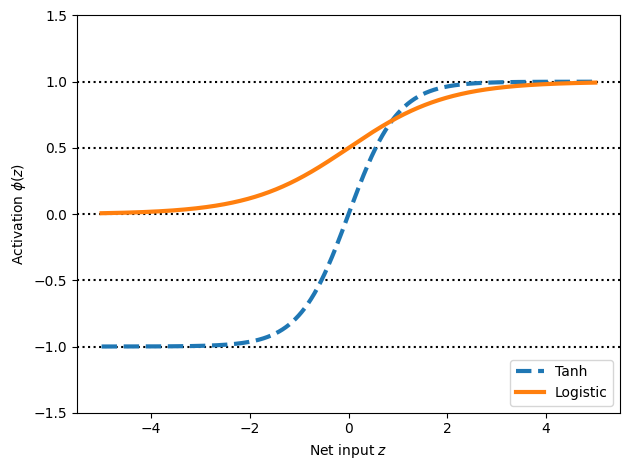

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('Net input $z$')
plt.ylabel('Activation $\\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act,
    linewidth=3, linestyle='--',
    label='Tanh')
plt.plot(z, log_act,
    linewidth=3,
    label='Logistic')
plt.legend(loc='lower right')
plt.tight_layout()

plt.show()

In [24]:
# tanh z NumPy:

np.tanh(z)

array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])

In [25]:
# tanh z PyTorch:

torch.tanh(torch.from_numpy(z))

tensor([-0.9999, -0.9999, -0.9999,  ...,  0.9999,  0.9999,  0.9999],
       dtype=torch.float64)

In [26]:
# Funkcja logistyczna z SciPy (moduł special):

from scipy.special import expit

expit(z)

array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])

In [27]:
# Funkcja logistyczna z PyTorch:

torch.sigmoid(torch.from_numpy(z))

tensor([0.0067, 0.0067, 0.0068,  ..., 0.9932, 0.9932, 0.9933],
       dtype=torch.float64)

In [28]:
# ReLU w PyTorch:

torch.relu(torch.from_numpy(z))

tensor([0.0000, 0.0000, 0.0000,  ..., 4.9850, 4.9900, 4.9950],
       dtype=torch.float64)

Lista dostępnych funkcji actywacji w module `torch.nn`:
https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions.